<a href="https://colab.research.google.com/github/mjdileep/Model-Explorer/blob/main/Modified_Mamba_Model_For_LLM_Generated_Text_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
import gc
import math
import random
import glob, os
from sklearn import set_config
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
seq_length = 128
unk_token_id = tokenizer.convert_tokens_to_ids('<|unk|>')

In [ ]:
train_essays = pd.read_csv('/content/drive/MyDrive/AIML/llm_detect/train_v2_drcat_02.csv')

train_essays.rename(columns={"label": "generated"}, inplace=True)
train_essays = train_essays.drop_duplicates(subset=['text'])
train_essays = train_essays[train_essays['generated'].notnull()]
train_essays.shape

(44868, 5)

In [ ]:
ext_train_essays = pd.read_csv('/content/drive/MyDrive/AIML/llm_detect/external_data.csv')
ext_train_essays.rename(columns={"label": "generated"}, inplace=True)
ext_train_essays = ext_train_essays.drop_duplicates(subset=['text'])
ext_train_essays = ext_train_essays[ext_train_essays['generated'].notnull()]
ext_train_essays.shape

(7071, 6)

In [ ]:
train_essays["tokens"] = train_essays.text.apply(lambda x: torch.tensor(tokenizer(x)["input_ids"]))
ext_train_essays["tokens"] = ext_train_essays.text.apply(lambda x: torch.tensor(tokenizer(x)["input_ids"]))


In [ ]:
#train_essays.to_pickle("/content/drive/MyDrive/AIML/llm_detect/train_essays_tiktoken.pt")
train_essays = pd.read_pickle("/content/drive/MyDrive/AIML/llm_detect/train_essays_tiktoken.pt")
#ext_train_essays.to_pickle("/content/drive/MyDrive/AIML/llm_detect/ext_train_essays_tiktoken.pt")
ext_train_essays = pd.read_pickle("/content/drive/MyDrive/AIML/llm_detect/ext_train_essays_tiktoken.pt")

In [ ]:
columns = ['Phones and driving', 'Car-free cities', 'Summer projects',
       'A Cowboy Who Rode the Waves',
       'Mandatory extracurricular activities', 'Exploring Venus',
       'Facial action coding system', 'The Face on Mars', 'Community service']
train_set  = train_essays[~train_essays.prompt_name.isin(columns)]
test_set  = train_essays[train_essays.prompt_name.isin(columns)]
c1_shape = test_set[test_set["generated"]==0].shape[0]
c2_shape = test_set[test_set["generated"]==1].shape[0]
N = min(c1_shape, c2_shape)
test_set = pd.concat([test_set[test_set["generated"]==0].iloc[:N,:], test_set[test_set["generated"]==1].iloc[:N,:]])
if c1_shape>c2_shape:
    train_set = pd.concat([train_set, test_set[test_set["generated"]==0].iloc[N:,:]])
else:
    train_set = pd.concat([train_set, test_set[test_set["generated"]==1].iloc[N:,:]])

test_set = pd.concat([test_set, ext_train_essays])


In [ ]:
print("train_set 0:", train_set[train_set["generated"]==0].shape)
print("train_set 1:", train_set[train_set["generated"]==1].shape)

print("test_set1 0:", test_set[test_set["generated"]==0].shape)
print("test_set1 1:", test_set[test_set["generated"]==1].shape)

train_set 0: (12963, 6)
train_set 1: (10582, 6)
test_set1 0: (9553, 9)
test_set1 1: (11348, 9)


In [ ]:
tokenized_text = test_set.tokens.tolist()

# Function to generate input-output pairs for pre-training
def generate_dataset(tokenized_text, min_seq_lenght = 64, max_seq_length=128):
    dataset = []
    for tokens in tokenized_text:
        for i in range(min_seq_lenght, len(tokens), 32):
            # Randomly select a sequence length up to max_sequence_length
            s = random.randint(min_seq_lenght, min(max_seq_length, i+1))
            input_sequence = tokens[i-s:i]
            target_word = tokens[i]
            dataset.append((input_sequence, target_word))
    return dataset

# Generate the dataset
pretraining_dataset = generate_dataset(tokenized_text)


In [ ]:
class PretrainDataset(Dataset):
    def __init__(self, data):
        self.data = pretraining_dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.data[index][1]
        if x.shape[0]<seq_length:
            x = torch.cat([torch.full((seq_length-x.shape[0],), 50256), x])
        return x, y

dataset_pretrain = PretrainDataset(pretraining_dataset)

In [ ]:
from __future__ import annotations
import math
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from einops import rearrange, repeat, einsum


@dataclass
class ModelArgs:
    d_model: int
    n_layer: int
    vocab_size: int
    d_state: int = 16
    expand: int = 2
    dt_rank: Union[int, str] = 'auto'
    d_conv: int = 4
    pad_vocab_size_multiple: int = 8
    conv_bias: bool = True
    bias: bool = False

    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)

        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)

        if self.vocab_size % self.pad_vocab_size_multiple != 0:
            self.vocab_size += (self.pad_vocab_size_multiple
                                - self.vocab_size % self.pad_vocab_size_multiple)


class ResidualBlock(nn.Module):
    def __init__(self, args: ModelArgs):
        """Simple block wrapping Mamba block with normalization and residual connection."""
        super().__init__()
        self.args = args
        self.mixer = MambaBlock(args)
        self.norm = RMSNorm(args.d_model)


    def forward(self, x):
        """
        Args:
            x: shape (b, l, d)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            output: shape (b, l, d)

        Official Implementation:
            Block.forward(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L297

            Note: the official repo chains residual blocks that look like
                [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> ...
            where the first Add is a no-op. This is purely for performance reasons as this
            allows them to fuse the Add->Norm.

            We instead implement our blocks as the more familiar, simpler, and numerically equivalent
                [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> ....

        """
        output = self.mixer(self.norm(x)) + x

        return output


class MambaBlock(nn.Module):
    def __init__(self, args: ModelArgs):
        """A single Mamba block, as described in Figure 3 in Section 3.4 in the Mamba paper [1]."""
        super().__init__()
        self.args = args

        self.in_proj = nn.Linear(args.d_model, args.d_inner * 2, bias=args.bias)

        self.conv1d = nn.Conv1d(
            in_channels=args.d_inner,
            out_channels=args.d_inner,
            bias=args.conv_bias,
            kernel_size=args.d_conv,
            groups=args.d_inner,
            padding=args.d_conv - 1,
        )

        # x_proj takes in `x` and outputs the input-specific Δ, B, C
        self.x_proj = nn.Linear(args.d_inner, args.dt_rank + args.d_state * 2, bias=False)

        # dt_proj projects Δ from dt_rank to d_in
        self.dt_proj = nn.Linear(args.dt_rank, args.d_inner, bias=True)

        A = repeat(torch.arange(1, args.d_state + 1), 'n -> d n', d=args.d_inner)
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(args.d_inner))
        self.out_proj = nn.Linear(args.d_inner, args.d_model, bias=args.bias)


    def forward(self, x):
        """Mamba block forward. This looks the same as Figure 3 in Section 3.4 in the Mamba paper [1].

        Args:
            x: shape (b, l, d)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            output: shape (b, l, d)

        Official Implementation:
            class Mamba, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L119
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311

        """
        (b, l, d) = x.shape

        x_and_res = self.in_proj(x)  # shape (b, l, 2 * d_in)
        (x, res) = x_and_res.split(split_size=[self.args.d_inner, self.args.d_inner], dim=-1)

        x = rearrange(x, 'b l d_in -> b d_in l')
        x = self.conv1d(x)[:, :, :l]
        x = rearrange(x, 'b d_in l -> b l d_in')

        x = F.silu(x)

        y = self.ssm(x)

        y = y * F.silu(res)

        output = self.out_proj(y)

        return output


    def ssm(self, x):
        """Runs the SSM. See:
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        Args:
            x: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            output: shape (b, l, d_in)

        Official Implementation:
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311

        """
        (d_in, n) = self.A_log.shape

        # Compute ∆ A B C D, the state space parameters.
        #     A, D are input independent (see Mamba paper [1] Section 3.5.2 "Interpretation of A" for why A isn't selective)
        #     ∆, B, C are input-dependent (this is a key difference between Mamba and the linear time invariant S4,
        #                                  and is why Mamba is called **selective** state spaces)

        A = -torch.exp(self.A_log.float())  # shape (d_in, n)
        D = self.D.float()

        x_dbl = self.x_proj(x)  # (b, l, dt_rank + 2*n)

        (delta, B, C) = x_dbl.split(split_size=[self.args.dt_rank, n, n], dim=-1)  # delta: (b, l, dt_rank). B, C: (b, l, n)
        delta = F.softplus(self.dt_proj(delta))  # (b, l, d_in)

        y = self.selective_scan(x, delta, A, B, C, D)  # This is similar to run_SSM(A, B, C, u) in The Annotated S4 [2]

        return y


    def selective_scan(self, u, delta, A, B, C, D):
        """Does selective scan algorithm. See:
            - Section 2 State Space Models in the Mamba paper [1]
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        This is the classic discrete state space formula:
            x(t + 1) = Ax(t) + Bu(t)
            y(t)     = Cx(t) + Du(t)
        except B and C (and the step size delta, which is used for discretization) are dependent on the input x(t).

        Args:
            u: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)
            delta: shape (b, l, d_in)
            A: shape (d_in, n)
            B: shape (b, l, n)
            C: shape (b, l, n)
            D: shape (d_in,)

        Returns:
            output: shape (b, l, d_in)

        Official Implementation:
            selective_scan_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L86
            Note: I refactored some parts out of `selective_scan_ref` out, so the functionality doesn't match exactly.

        """
        (b, l, d_in) = u.shape
        n = A.shape[1]

        # Discretize continuous parameters (A, B)
        # - A is discretized using zero-order hold (ZOH) discretization (see Section 2 Equation 4 in the Mamba paper [1])
        # - B is discretized using a simplified Euler discretization instead of ZOH. From a discussion with authors:
        #   "A is the more important term and the performance doesn't change much with the simplification on B"
        deltaA = torch.exp(einsum(delta, A, 'b l d_in, d_in n -> b l d_in n'))
        deltaB_u = einsum(delta, B, u, 'b l d_in, b l n, b l d_in -> b l d_in n')

        # Perform selective scan (see scan_SSM() in The Annotated S4 [2])
        x = torch.zeros((b, d_in, n), device=deltaA.device)
        ys = []
        for i in range(l):
            x = deltaA[:, i] * x + deltaB_u[:, i]
            y = einsum(x, C[:, i, :], 'b d_in n, b n -> b d_in')
            ys.append(y)
        y = torch.stack(ys, dim=1)  # shape (b, l, d_in)

        y = y + u * D

        return y


class RMSNorm(nn.Module):
    def __init__(self,
                 d_model: int,
                 eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))


    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

        return output



In [ ]:
n_dim = 32
#device="cpu"
device="cuda"
n_layers = 2


class FCBlock(nn.Module):
    def __init__(self, dim_in, dim_out, dropout, act="RELU"):
        super().__init__()
        self.fc = nn.Linear(dim_in, dim_out)
        self.act = nn.RReLU()
        self.d = nn.Dropout(dropout)
    def forward(self, x):
        return  self.d(self.act(self.fc(x)))


class MambaLLM(nn.Module):
    def __init__(self):
      super().__init__()
      self.args = ModelArgs(d_model= n_dim, n_layer=n_layers,vocab_size=50264)
      self.embedding = nn.Embedding(self.args.vocab_size, n_dim)
      self.layers = nn.ModuleList([ResidualBlock(self.args) for _ in range(self.args.n_layer)])
      self.norm_f = RMSNorm(self.args.d_model)

      self.lm_head = nn.Linear(self.args.d_model, self.args.vocab_size, bias=False)
      self.lm_head.weight = self.embedding.weight

    def forward(self, x, encode=False):
        out = self.embedding(x)
        for layer in self.layers:
            out = layer(out)
        out = self.norm_f(out)
        if encode:
            return out[:,-1,:]
        return self.lm_head(out)[:,-1,:]


mamba = MambaLLM().to(device)

In [ ]:
# Initialize the model, loss function, and optimizer
from torch.utils.data import DataLoader, random_split
batch_size=128
vocab_size = 50264
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mamba.parameters(), lr=1e-3)
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset_pretrain))
val_size = len(dataset_pretrain) - train_size
train_dataset, val_dataset = random_split(dataset_pretrain, [train_size, val_size])

# Create DataLoader for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    mamba.train()
    total_loss = 0
    train_dataloader_iter = tqdm(train_dataloader, desc='', leave=True)
    for batch in train_dataloader_iter:
        input_sequences, target_words = batch
        optimizer.zero_grad()
        logits = mamba(input_sequences.to(device))
        loss = criterion(logits.view(-1, vocab_size), target_words.to(device).view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")

# Validation loop
mamba.eval()
total_val_loss = 0

with torch.no_grad():
    val_dataloader_iter = tqdm(val_dataloader, desc='', leave=True)
    for batch in val_dataloader_iter:
        input_sequences, target_words = batch
        logits = mamba(input_sequences.to(device))
        val_loss = criterion(logits.view(-1, vocab_size), target_words.to(device).view(-1))
        total_val_loss += val_loss.item()

average_val_loss = total_val_loss / len(val_dataloader)
print(f"Validation Loss: {average_val_loss}")

# Save the trained model if needed
torch.save({
            'model_state_dict': mamba.state_dict(),
            }, '/content/drive/MyDrive/AIML/llm_detect/models/pretrained_language_model.pth')

del train_dataloader, val_dataloader
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 1844/1844 [37:19<00:00,  1.21s/it]


Epoch 1/1, Loss: 18.25070194929127


100%|██████████| 461/461 [00:31<00:00, 14.73it/s]

Validation Loss: 12.457054694666004


In [ ]:
def pad(tokens):
    index = tokens.shape[0]
    if index<seq_length:
        tokens = torch.cat([torch.full((seq_length-tokens.shape[0],), 50256), tokens])
    return tokens

train_set["tokens"] = train_set.tokens.apply(lambda x: pad(x))
test_set["tokens"] = test_set.tokens.apply(lambda x: pad(x))

In [ ]:
class LLMDetectModel(nn.Module):
    def __init__(self, weights_path):
        super().__init__()
        checkpoint = torch.load(weights_path, map_location=device)
        self.mamba = MambaLLM()
        self.mamba.load_state_dict(checkpoint['model_state_dict'])
        self.mamba.lm_head.requires_grad = False

        self.fc1 = FCBlock(n_dim, n_dim, 0.1)
        self.fc2 = FCBlock(n_dim, n_dim, 0.1)
        self.out = nn.Linear(n_dim, 2)


    def forward(self, x):
        out = self.mamba(x, encode=True)
        out = self.fc2(self.fc1(out))
        out = self.out(out)

        return out.view(-1, 2).to(float)

model = LLMDetectModel("/content/drive/MyDrive/AIML/llm_detect/models/pretrained_language_model.pth").to(device)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data["tokens"]
        self.targets = data["generated"]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        l = self.data.iloc[index].shape[0]
        r = np.random.randint(0,l-seq_length+1)
        x = self.data.iloc[index][r:r+seq_length]
        y = self.targets.iloc[index]
        return x, int(y)

class CustomDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super(CustomDataLoader, self).__init__(*args, **kwargs)

    def __iter__(self):
        data_iter = super(CustomDataLoader, self).__iter__()
        return data_iter
dataset_train = CustomDataset(train_set)
dataset_test = CustomDataset(test_set)

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/AIML/llm_detect/models/model_last_alt.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
max_test_auc=0.0

In [ ]:
from sklearn.metrics import roc_auc_score

overfit_count=0
patience = 100
num_epochs = 1000
learning_rate = 1e-3
batch_size = 64
epoch_gamma = None
lambda_reg = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Create data loaders for training and validation using your custom DataLoader
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=dataset_test, batch_size=512)
# Train your model
for epoch in range(num_epochs):
    model.train()
    train_loader_iter = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True)
    whole_y_pred=np.array([])
    whole_y_t=np.array([])
    i = 0
    train_loss = 0.0
    for inputs, targets in train_loader_iter:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        y_pred = nn.functional.softmax(outputs)[:,-1]
        regularization_term = 0.5 * lambda_reg * sum(p.norm(2) ** 2 for p in model.parameters())
        loss = nn.functional.cross_entropy(outputs, targets.to(device=device).view(-1))
        reg_loss = loss+ regularization_term
        reg_loss.backward()
        optimizer.step()
        whole_y_pred = np.append(whole_y_pred, y_pred.clone().detach().cpu().numpy())
        whole_y_t    = np.append(whole_y_t, targets.clone().detach().cpu().numpy())
        i+=1
        train_loss += loss.item()
    train_loss/=i
    # Validation
    model.eval()

    all_test_preds = np.array([])
    all_test_t = np.array([])
    i=0
    test_loss = 0.0
    with torch.no_grad():
        valid_loader_iter = tqdm(valid_loader, desc='', leave=True)
        for  inputs, targets in valid_loader_iter:
            outputs = model(inputs.to(device))
            loss = nn.functional.cross_entropy(outputs, targets.to(device=device).view(-1))
            y_pred = nn.functional.softmax(outputs)[:,-1].detach().cpu().numpy()
            y_t = targets.detach().cpu().numpy()
            all_test_preds=np.concatenate([all_test_preds,y_pred],axis=0)
            all_test_t = np.concatenate([all_test_t,y_t],axis=0)
            test_loss+=loss.item()
            i+=1
    test_loss/=i
    s = 1000
    n2 = np.random.randint(0,len(whole_y_pred)-s)
    whole_y_pred=np.concatenate([all_test_preds,whole_y_pred[n2:n2+s]],axis=0)
    whole_y_t=np.concatenate([all_test_t,whole_y_t[n2:n2+s]],axis=0)
    try:
        combined_roc_val = roc_auc_score(whole_y_pred>=0.5, whole_y_t)
    except:
        combined_roc_val=-1
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {test_loss},  Combined AUC: {combined_roc_val}")

    if max_test_auc < combined_roc_val:
        max_test_auc = combined_roc_val
        torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': combined_roc_val,
                    }, "/content/drive/MyDrive/AIML/llm_detect/models/model_best_alt.pt")
        overfit_count=0
    else:
        overfit_count +=1
        if overfit_count> patience:
            break

    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': combined_roc_val,
                }, "/content/drive/MyDrive/AIML/llm_detect/models/model_last_alt.pt")
del train_loader
gc.collect()
torch.cuda.empty_cache()


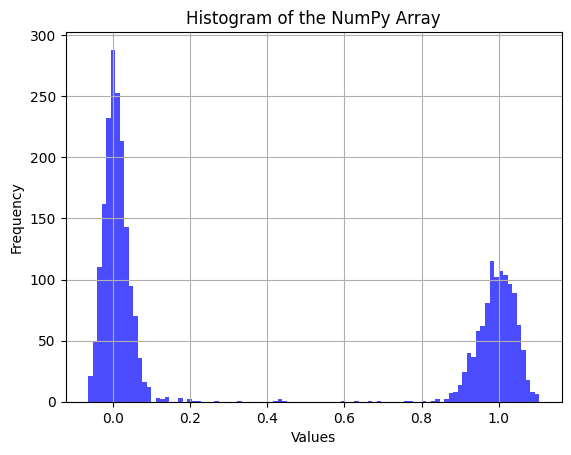

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a random NumPy array for demonstration purposes
data = whole_y_pred

# Plot the histogram
plt.hist(data, bins=100, color='blue', alpha=0.7)
plt.title('Histogram of the NumPy Array')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


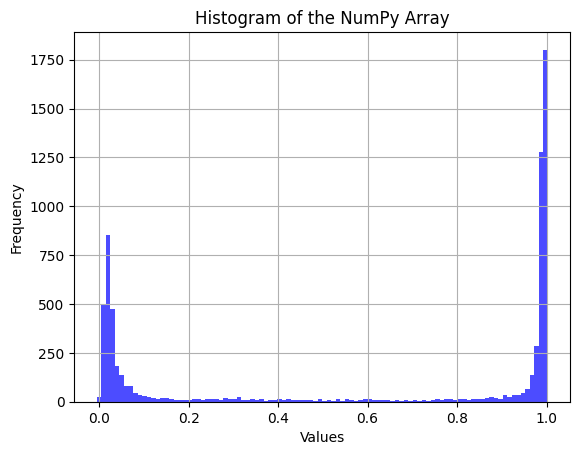

In [ ]:
data = all_test_preds

# Plot the histogram
plt.hist(data, bins=100, color='blue', alpha=0.7)
plt.title('Histogram of the NumPy Array')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
max_test_auc

0.9664968625217287

In [ ]:
all_test_t.shape

(20901,)